**여러 선형 모델의 파라미터를 해석적으로 구하고 다양한 최적화 방식을 사용하여 비용 함수를 훈련 세트에 대해 최소화시킨다.**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import os
# 깔끔한 그래프 출력을 위해
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형 회귀

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_plot


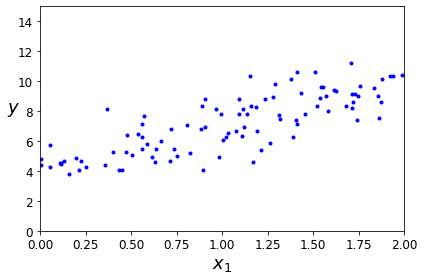

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

**정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가한다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.12718463],
       [2.92050606]])

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가한다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.12718463],
       [9.96819674]])

그림 저장: linear_model_predictions_plot


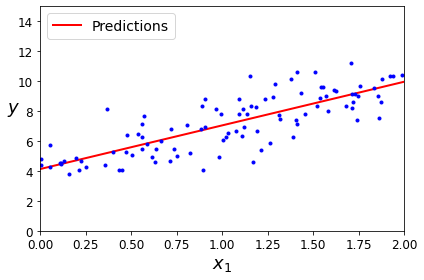

In [7]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.12718463]), array([[2.92050606]]))

In [9]:
lin_reg.predict(X_new)

array([[4.12718463],
       [9.96819674]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있다:

In [10]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 쓴다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.12718463],
       [2.92050606]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산한다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)이다(Moore–Penrose 유사역행렬이다). `np.linalg.pinv()`을 사용해서 유사역행렬을 직접 계산할 수 있다:

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.12718463],
       [2.92050606]])

# 경사 하강법
## 배치 경사 하강법

**비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

**경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$


In [12]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)  # 랜덤 초기화
for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

array([[4.12718463],
       [2.92050606]])

In [14]:
X_new_b.dot(theta)

array([[4.12718463],
       [9.96819674]])

In [15]:
theta_path_bgd = []


def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, -1, 12])
    plt.title(rf"$\eta = {eta}$", fontsize=16)

그림 저장: gradient_descent_plot


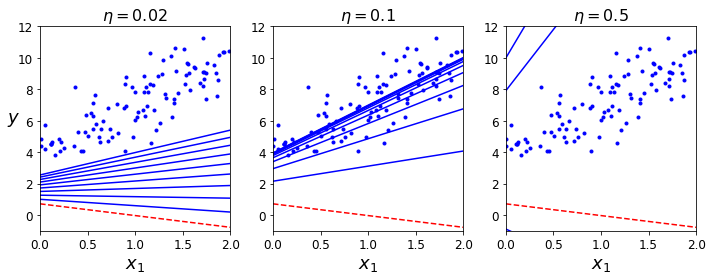

In [16]:
theta = np.random.randn(2, 1)  # 무작위 초기화
plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

## 확률적 경사 하강법

In [17]:
theta_path_sgd = []
m = len(X_b)

그림 저장: sgd_plot


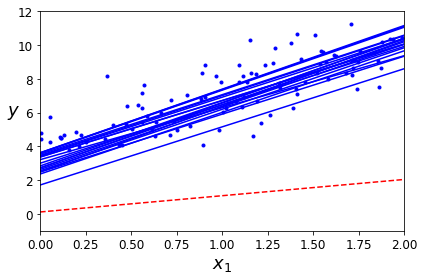

In [18]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터


def learning_schedule(t):
    return t0 / (t + t1)


theta = np.random.randn(2, 1)  # 랜덤 초기화
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, -1, 12])
save_fig("sgd_plot")
plt.show()

In [19]:
theta

array([[4.16932355],
       [2.94969938]])

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.08055493]), array([2.88271456]))

## 미니배치 경사 하강법

In [22]:
theta_path_mgd = []
n_iterations = 50
minibatch_size = 20
theta = np.random.randn(2, 1)  # 랜덤 초기화
t0, t1 = 200, 1000


def learning_schedule(t):
    return t0 / (t + t1)


t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [23]:
theta

array([[4.0726834 ],
       [2.83261377]])

In [24]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


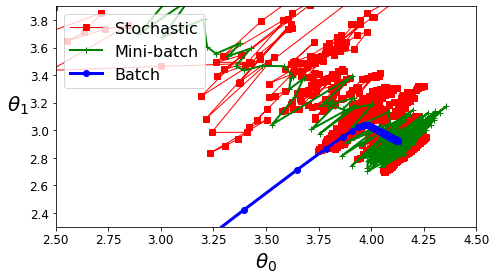

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# 다항 회귀

In [26]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


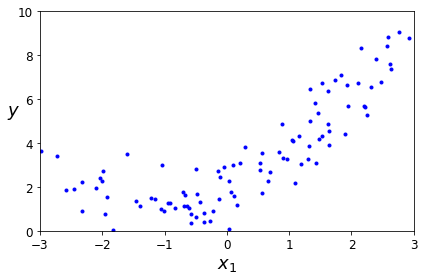

In [27]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.63922007])

In [29]:
X_poly[0]

array([2.63922007, 6.96548256])

In [30]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.92754171]), array([[1.10303176, 0.48987062]]))

그림 저장: quadratic_predictions_plot


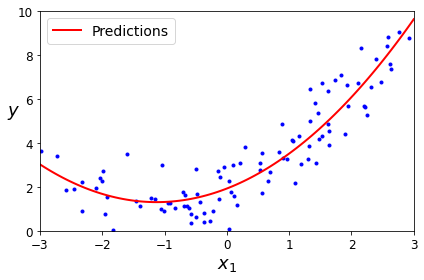

In [31]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

그림 저장: high_degree_polynomials_plot


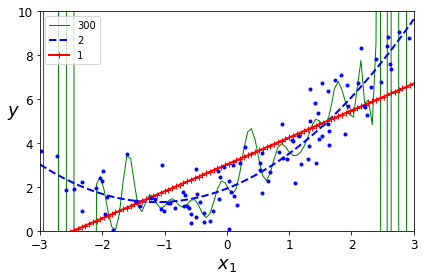

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression(n_jobs=-1)
    polynomial_regression = Pipeline(
        [("poly_features", polybig_features), ("std_scaler", std_scaler), ("lin_reg", lin_reg)]
    )
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

# 학습 곡선

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

그림 저장: underfitting_learning_curves_plot


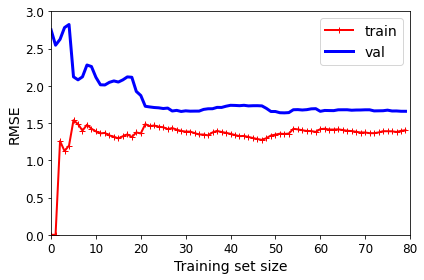

In [34]:
lin_reg = LinearRegression(n_jobs=-1)
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

그림 저장: learning_curves_plot


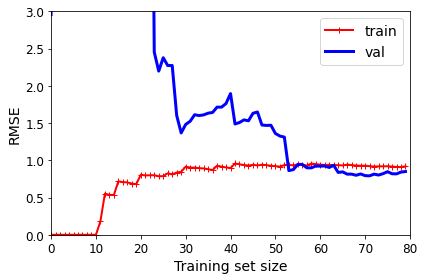

In [35]:
polynomial_regression = Pipeline(
    [("poly_features", PolynomialFeatures(degree=10, include_bias=False)), ("lin_reg", LinearRegression(n_jobs=-1))]
)
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

# 규제가 있는 선형 모델

## 릿지 회귀

In [36]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

**릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

In [37]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.72336343]])

In [38]:
ridge_reg = Ridge(solver="sag")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.72336936]])

그림 저장: ridge_regression_plot


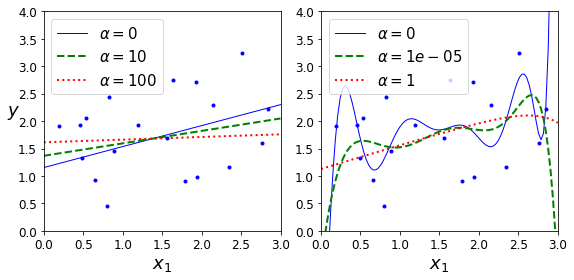

In [39]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression(n_jobs=-1)
        if polynomial:
            model = Pipeline(
                [
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()), ("regul_reg", model)
                ]
            )
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=rf"$\alpha = {alpha}$")
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])


plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100))
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10 ** -5, 1))
save_fig("ridge_regression_plot")
plt.show()

In [40]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.63778554])

**라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

## 라쏘 회귀

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e+00, tolerance: 1.402e-03
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


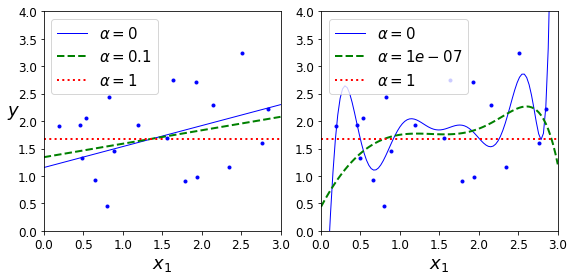

In [41]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1))
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10 ** -7, 1))
save_fig("lasso_regression_plot")
plt.show()

In [42]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.70988465])

## 엘라스틱넷

**엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

In [43]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.71568201])

## 조기 종료

In [44]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X ** 2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5)

In [45]:
from copy import deepcopy

poly_scaler = Pipeline(
    [("poly_features", PolynomialFeatures(degree=90, include_bias=False)), ("std_scaler", StandardScaler())]
)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작한다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그래프를 그린다:

그림 저장: early_stopping_plot


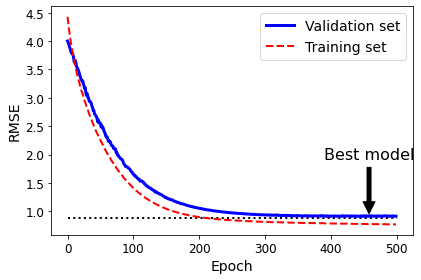

In [46]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])
plt.annotate(
    "Best model",
    xy=(best_epoch, best_val_rmse),
    xytext=(best_epoch, best_val_rmse + 1),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=16
)
best_val_rmse -= 0.03  # 그래프를 더 보기 좋게 만들기 위해
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [47]:
best_epoch, best_model

(458,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              tol=-inf, warm_start=True))

In [48]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]
J = (1 / len(Xr) * np.sum((T.dot(Xr.T) - yr.T) ** 2, axis=1)).reshape(t1.shape)
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)
t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]
t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


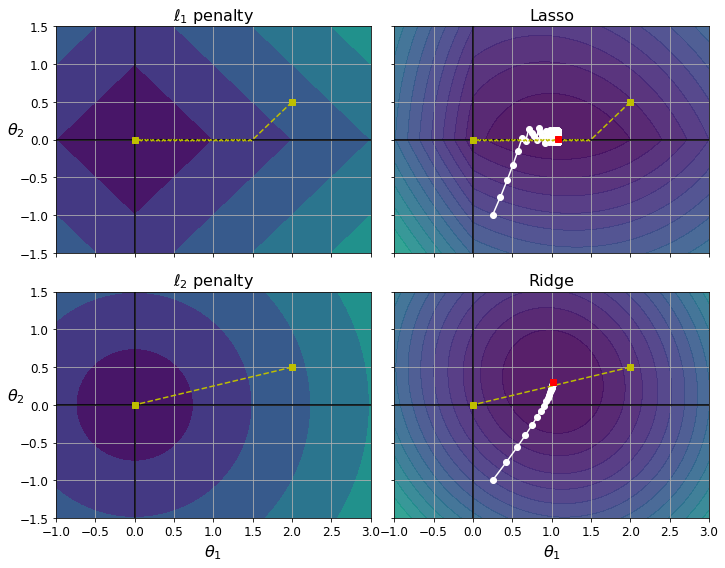

In [49]:
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2 / len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0, 2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]
    levelsJ = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN = np.linspace(0, np.max(N), 10)
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1) / 3, np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(rf"$\ell_{i + 1}$ penalty", fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)
    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
save_fig("lasso_vs_ridge_plot")
plt.show()

# 로지스틱 회귀

## 결정 경계

그림 저장: logistic_function_plot


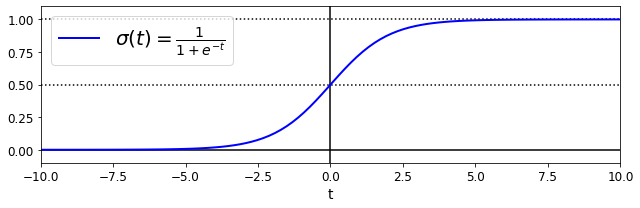

In [50]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel('t')
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

**하나의 훈련 샘플에 대한 비용 함수**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$


**로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$


**로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

In [51]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [52]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [53]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(int)  # Iris virginica이면 1 아니면 0

In [54]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X, y)

LogisticRegression(n_jobs=-1)

그림 저장: logistic_regression_plot


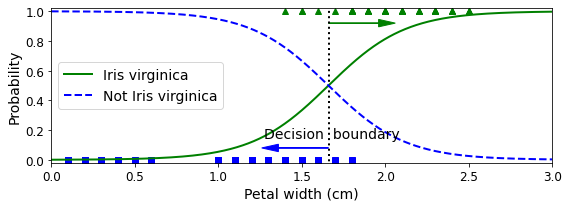

In [55]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
plt.figure(figsize=(8, 3))
plt.plot(X[y == 0], y[y == 0], "bs")
plt.plot(X[y == 1], y[y == 1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary + 0.02, 0.15, "Decision  boundary", fontsize=14, color='k', ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [56]:
decision_boundary

array([1.66066066])

In [57]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## 소프트맥스 회귀

그림 저장: logistic_regression_contour_plot


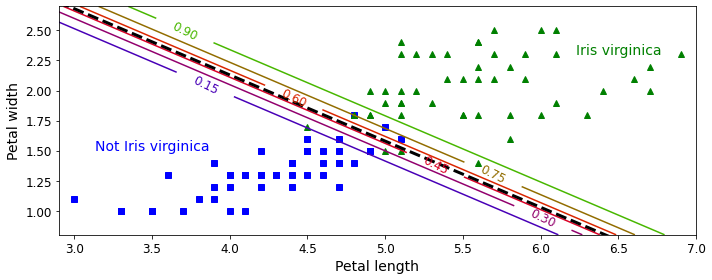

In [58]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(int)
log_reg = LogisticRegression(C=10 ** 10, n_jobs=-1)
log_reg.fit(X, y)
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1), np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = log_reg.predict_proba(X_new)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs")
plt.plot(X[y == 1, 0], X[y == 1, 1], "g^")
zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color='b', ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color='g', ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

**소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$

**크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

**클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

In [59]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", C=10, n_jobs=-1)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1)

그림 저장: softmax_regression_contour_plot


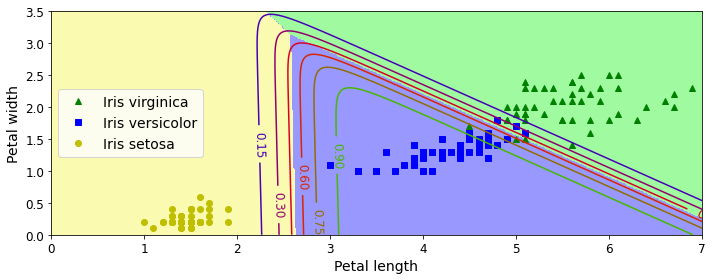

In [60]:
from matplotlib.colors import ListedColormap

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1), np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [61]:
softmax_reg.predict([[5, 2]])

array([2])

In [62]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
(사이킷런을 사용하지 않고)

먼저 데이터를 로드한다. 앞서 사용했던 Iris 데이터셋을 재사용한다.

In [63]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

모든 샘플에 편향을 추가한다 ($x_0 = 1$):

In [64]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누는 가장 쉬운 방법은 사이킷런의 `train_test_split()` 함수를 사용하는 것이다. 하지만 이 연습의 목적은 직접 만들어 보면서 알고리즘을 이해하는 것이므로 다음과 같이 수동으로 나누어 본다:

In [65]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)
test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size
rnd_indices = np.random.permutation(total_size)
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃은 클래스 인덱스(0, 1 그리고 2)이지만 소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 타깃 클래스의 확률이다. 각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0이다(다른 말로 하면 주어진 샘플에 대한 클래스 확률이 원-핫 벡터이다). 클래스 인덱스를 원-핫 벡터로 바꾸는 간단한 함수를 작성한다:

In [66]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

10개 샘플만 넣어 이 함수를 테스트해 본다:

In [67]:
to_one_hot(y_train[:10])

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

잘 된다, 이제 훈련 세트와 테스트 세트의 타깃 클래스 확률을 담은 행렬을 만든다:

In [68]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

이제 소프트맥스 함수를 만든다. 다음 공식을 참고한다:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [69]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

훈련을 위한 준비를 거의 마쳤다. 입력과 출력의 개수를 정의한다:

In [70]:
n_inputs = X_train.shape[1]  # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))  # == 3 (3개의 붓꽃 클래스)

이제 좀 복잡한 훈련 파트이다! 이론적으로는 간단하다. 그냥 수학 공식을 파이썬 코드로 바꾸기만 하면 된다. 하지만 실제로는 꽤 까다로운 면이 있다. 특히, 항이나 인덱스의 순서가 뒤섞이기 쉽다. 제대로 작동할 것처럼 코드를 작성했더라도 실제 제대로 계산하지 못한다. 확실하지 않을 때는 각 항의 크기를 기록하고 이에 상응하는 코드가 같은 크기를 만드는지 확인한다. 각 항을 독립적으로 평가해서 출력해 보는 것도 좋다. 사실 사이킷런에 이미 잘 구현되어 있기 때문에 이렇게 할 필요는 없다. 하지만 직접 만들어 보면 어떻게 작동하는지 이해하는데 도움이 된다.

구현할 공식은 비용함수이다:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

그리고 그레이디언트 공식이다:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

$\hat{p}_k^{(i)} = 0$이면 $\log\left(\hat{p}_k^{(i)}\right)$를 계산할 수 없다. `nan` 값을 피하기 위해 $\log\left(\hat{p}_k^{(i)}\right)$에 아주 작은 값 $\epsilon$을 추가한다.

In [71]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
Theta = np.random.randn(n_inputs, n_outputs)
for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 3.4859227737944987
500 0.9267762383857221
1000 0.7312756649334168
1500 0.6178474735753532
2000 0.5467179579330822
2500 0.49781887752341236
3000 0.4616741250330125
3500 0.4335237792908414
4000 0.4107612899055323
4500 0.39183938785720746
5000 0.3757749808744858


소프트맥스 모델을 훈련시켰다. 모델 파라미터를 확인해 본다:

In [72]:
Theta

array([[ 2.50418623, -0.34589762, -3.18928793],
       [ 0.40894018,  0.67413124,  0.7665988 ],
       [-2.37442108,  0.70621045,  2.35791696]])

검증 세트에 대한 예측과 정확도를 확인해 본다:

In [73]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

모델이 매우 잘 작동하는 것 같다. 연습을 위해서 $\ell_2$ 규제를 조금 추가해 보겠다. 다음 코드는 위와 거의 동일하지만 손실에 $\ell_2$ 페널티가 추가되었고 그래디언트에도 항이 추가되었다(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않는다). 학습률 `eta`도 증가시켜 보겠다.

In [74]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
Theta = np.random.randn(n_inputs, n_outputs)
for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1 / 2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 1.3757270404409376
500 0.5220401077505629
1000 0.49856751912118363
1500 0.49187613102258937
2000 0.48938960253138714
2500 0.48838668159646564
3000 0.48796546967432597
3500 0.48778440378417204
4000 0.487705453799345
4500 0.48767071828967234
5000 0.4876553468641135


추가된 $\ell_2$ 페널티 때문에 이전보다 손실이 조금 커보이지만 더 잘 작동하는 모델이 되었을까? 확인해 본다:

In [75]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

운이 좋은 검증 세트일지 모르지만 잘 된 것은 맞다.

이제 조기 종료를 추가해 본다. 이렇게 하려면 매 반복에서 검증 세트에 대한 손실을 계산해서 오차가 증가하기 시작할 때 멈춰야 한다.

In [76]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty
Theta = np.random.randn(n_inputs, n_outputs)
for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1 / 2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(f"{iteration} {loss}")
    if loss < best_loss:
        best_loss = loss
    else:
        print(f"{iteration - 1} {best_loss}")
        print(f"{iteration} {loss} 조기 종료!")
        break

0 1.8196494556742067
500 0.5459531667032942
1000 0.5051942466837549
1500 0.4927003282601976
2000 0.48742324511941093
2500 0.48490123069552105
3000 0.48359196922497705
3500 0.48286755018374133
4000 0.4824460629292701
4500 0.48219107234130154
5000 0.4820321990928198


In [77]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

여전하지만 더 빠르다.

이제 전체 데이터셋에 대한 모델의 예측을 그래프로 나타내 보겠다:

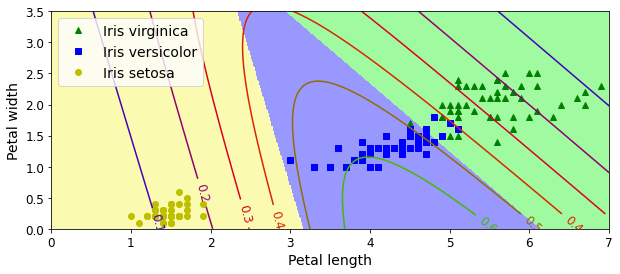

In [78]:
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1), np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]
logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

이제 테스트 세트에 대한 모델의 최종 정확도를 측정해 본다:

In [79]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

훈련 세트와 검증 세트, 테스트 세트를 어떻게 샘플링했는지에 따라 매우 다른 결과를 얻을 수 있다. 몇 번 랜덤 시드를 바꾸고 이 코드를 다시 실행해 보면 결과가 달라지는 것을 확인할 수 있다.